# Rank analysis  

## `SF2H` dataset

Procedure :
- count occurences of events (non directed) in training set
- in test set, compute `cnt_class` variable such as :
    - `0` : event never seen in training set
    - `1` : event seen between 1 and 5 times
    - `2` : event see more than 5 times
    
Results :
- Is there any relation between frequency of occurences in training set and *observed* edge order in test set ? 
    * correlation between `cnt_class` and `true_ranks` is **positive ($R^2$=0.38)**. This correlation tends to vanish over time.
- Is there any relation between frequency of occurences in training set and *predicted* edge order in test set ?
    * no correlation between `cnt_class` and `pred_ranks` 
- How the frequency of occurences impacts the predicted ranks ?
    * events that have been seen in the past are predicted to happen too soon compared to reality
    * events that have never been seen in the past are predicted to happen later compared to reality  
- Analysis of predicted ranks by batch of edges (3 batches):
    * the first batch of predicted ranks are the **most correlated** to true ranks : *Kendall $\tau$* is higher than the overall metric at each $k$.
    * second and last thirds are less correlated to true ranks
- Analysis of predicted ranks by frequency in training :
    * considering short window of prediction, e.g @5, edges that have been seen between 1 and 5 times are more well predicted than others.
    * however, on the long run, edges that have been seen more than 5 times are more well predicted.


**Libraries**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Analysis

In [2]:
# Import SF2H training data
def func(x):
    if x['src']<x['dest']:
        return str(x['src'])+str(x['dest']) 
    else:
        return str(x['dest'])+str(x['src'])

df_train = pd.read_pickle('SF2H_train.pkl')
df_train['label'] = df_train.apply(func, axis=1)

global dic_cnt 
dic_cnt = dict(df_train['label'].value_counts())

# Count occurences
def return_count(x):
    return dic_cnt.get(x['label'])

df_train['cnt'] = df_train.apply(return_count, axis=1)
df_train.head()

,t,i,j,src,dest,label,cnt
0,32520,1467,1591,36,144,36144,17
1,32560,1513,1591,75,144,75144,1
2,32700,1591,1467,144,36,36144,17
3,32720,1591,1467,144,36,36144,17
4,32740,1591,1467,144,36,36144,17


Most frequent events :
        src  dest   cnt
29249  195   211  1220
1532   108    86   524
26646  335    55   424


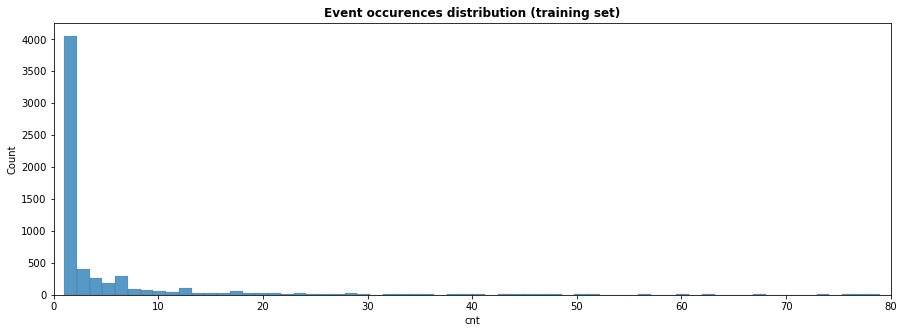

In [3]:
# Distribution of event count
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(df_train[['label', 'cnt']].drop_duplicates()['cnt'], bins=1000)
plt.xlim(0, 80)
plt.title('Event occurences distribution (training set)', weight='bold')

max_event = df_train.sort_values('cnt', ascending=False)[['src', 'dest', 'cnt']].drop_duplicates().head(3)

print(f'Most frequent events :\n {max_event}')

In [4]:
# Compute classes of cnt
def compute_class(cnt):
    if cnt == 0:
        return '0'
    elif cnt > 0 and cnt <= 5:
        return '1'
    else:
        return '2'

def load_data(model_name, feat_struct, metric):
    return pd.read_pickle(f'preds_{feat_struct}_{model_name}_{metric}.pkl')

def preprocess_data(model_name, feat_struct, metric):

    # Load data
    df = load_data(model_name, feat_struct, metric)

    # Add label
    df['label'] = df.apply(func, axis=1)

    # Add cnt occurences
    df['cnt'] = df.apply(return_count, axis=1)
    df['cnt'] = df['cnt'].fillna(0)

    # Compute rank difference
    df['rank_diff'] = df['pred_ranks'] - df['true_ranks']
    df['rank_diff_abs'] = np.abs(df['rank_diff'])
    #df['rank_diff_norm'] = df['rank_diff'].apply(lambda x: (x-df['rank_diff'].mean()) / df['rank_diff'].std())
    df['rank_diff_norm'] = df['rank_diff'].apply(lambda x: x / df.shape[0])
    df['rank_diff_abs_norm'] = df['rank_diff_abs'].apply(lambda x: x / df.shape[0])

    # Compute count classes
    df['cnt_class'] = df['cnt'].apply(compute_class)
    
    return df

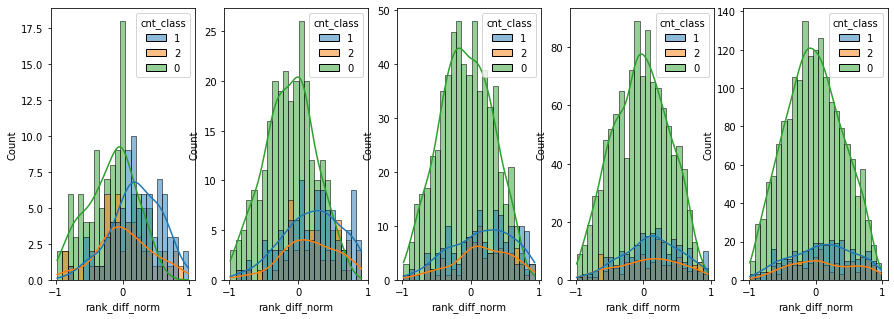

In [5]:
model_names = ['GraphConv']
feat_structs = ['agg_simp']
metrics_at = ['kendall@5', 'kendall@10', 'kendall@25', 'kendall@50', 'kendall@100']

evol_0, evol_1, evol_2 = [], [], []
df_tot_graphConv_aggSimp = pd.DataFrame()

fig, axes = plt.subplots(1, len(metrics_at), figsize=(15,5))
for model_name, feat_struct in zip(model_names, feat_structs):
    for i, metric in enumerate(metrics_at):
        df = preprocess_data(model_name, feat_struct, metric)
        #sns.scatterplot(data=df, x='cnt_class', y='rank_diff_abs', hue='true_ranks', ax=axes[0, i])
        #sns.scatterplot(data=df, x='rank_diff_abs', y='cnt_class', hue='true_ranks', ax=axes[0, i])
        sns.histplot(data=df, x='rank_diff_norm', hue='cnt_class', ax=axes[i], kde=True, bins=25)
        #sns.scatterplot(data=df, x='true_ranks', y='pred_ranks', ax=axes[1, i], hue='cnt_class')
        #sns.scatterplot(data=df, x=range(len(df['rank_diff_norm'])), y='rank_diff_norm', hue='cnt_class', ax=axes[1, i])


        count_classes = df['cnt_class'].value_counts()
        evol_0.append(count_classes[0])
        evol_1.append(count_classes[1])
        evol_2.append(count_classes[2])

        df_tot_graphConv_aggSimp = pd.concat([df_tot_graphConv_aggSimp, df])

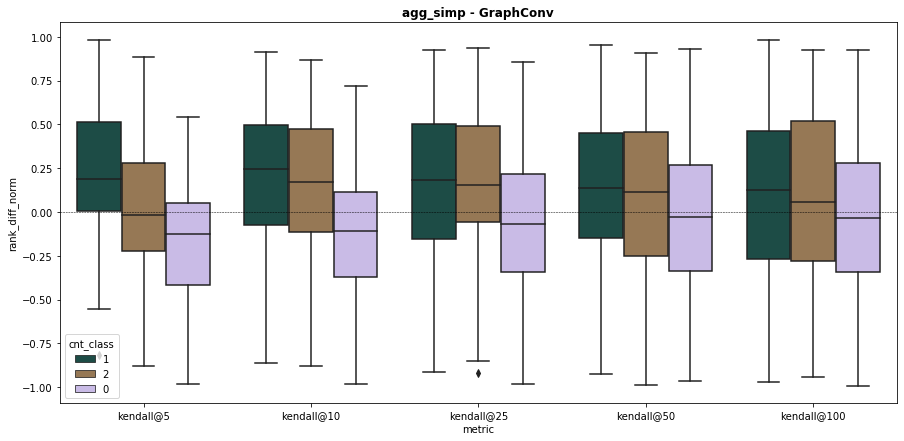

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.boxplot(
        #data=df_tot.loc[(df_tot['metric']=='kendall@5') | (df_tot['metric']=='kendall@10')], 
        data=df_tot_graphConv_aggSimp,
        x='metric', y='rank_diff_norm', 
        palette='cubehelix', hue='cnt_class')
g.axhline(0, ls='--', color='black', linewidth=0.5)
plt.title(f'{feat_structs[0]} - {model_name}', weight='bold');

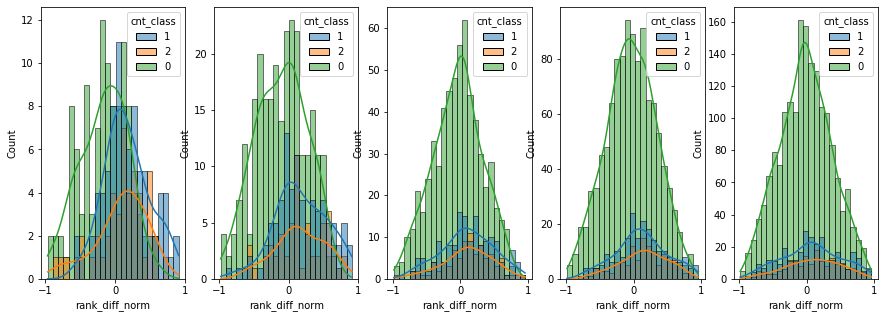

In [7]:
model_names = ['GraphSage']
feat_structs = ['temporal_edges']
metrics_at = ['kendall@5', 'kendall@10', 'kendall@25', 'kendall@50', 'kendall@100']

evol_0, evol_1, evol_2 = [], [], []
df_tot_graphSage_tempEdges = pd.DataFrame()

fig, axes = plt.subplots(1, len(metrics_at), figsize=(15,5))
for model_name, feat_struct in zip(model_names, feat_structs):
    for i, metric in enumerate(metrics_at):
        df = preprocess_data(model_name, feat_struct, metric)
        #sns.scatterplot(data=df, x='cnt_class', y='rank_diff_abs', hue='true_ranks', ax=axes[0, i])
        sns.histplot(data=df, x='rank_diff_norm', hue='cnt_class', ax=axes[i], kde=True, bins=25)
        #sns.scatterplot(data=df, x='rank_diff_abs', y='cnt_class', hue='true_ranks', ax=axes[0, i])
        #sns.scatterplot(data=df, x='true_ranks', y='pred_ranks', ax=axes[1, i], hue='cnt_class')
        #sns.scatterplot(data=df, x=range(len(df['rank_diff_norm'])), y='rank_diff_norm', hue='cnt_class', ax=axes[1, i])

        count_classes = df['cnt_class'].value_counts()
        evol_0.append(count_classes[0])
        evol_1.append(count_classes[1])
        evol_2.append(count_classes[2])

        df_tot_graphSage_tempEdges = pd.concat([df_tot_graphSage_tempEdges, df])

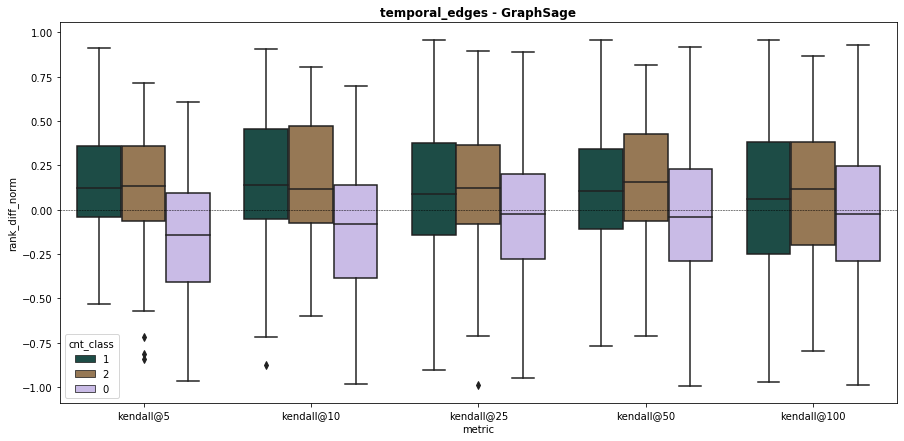

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
g = sns.boxplot(
        #data=df_tot.loc[(df_tot['metric']=='kendall@5') | (df_tot['metric']=='kendall@10')], 
        data=df_tot_graphSage_tempEdges,
        x='metric', y='rank_diff_norm', 
        palette='cubehelix', hue='cnt_class')
g.axhline(0, ls='--', color='black', linewidth=0.5)
plt.title(f'{feat_structs[0]} - {model_name}', weight='bold');

Text(0.5, 1.0, 'PDAG - GraphSage')

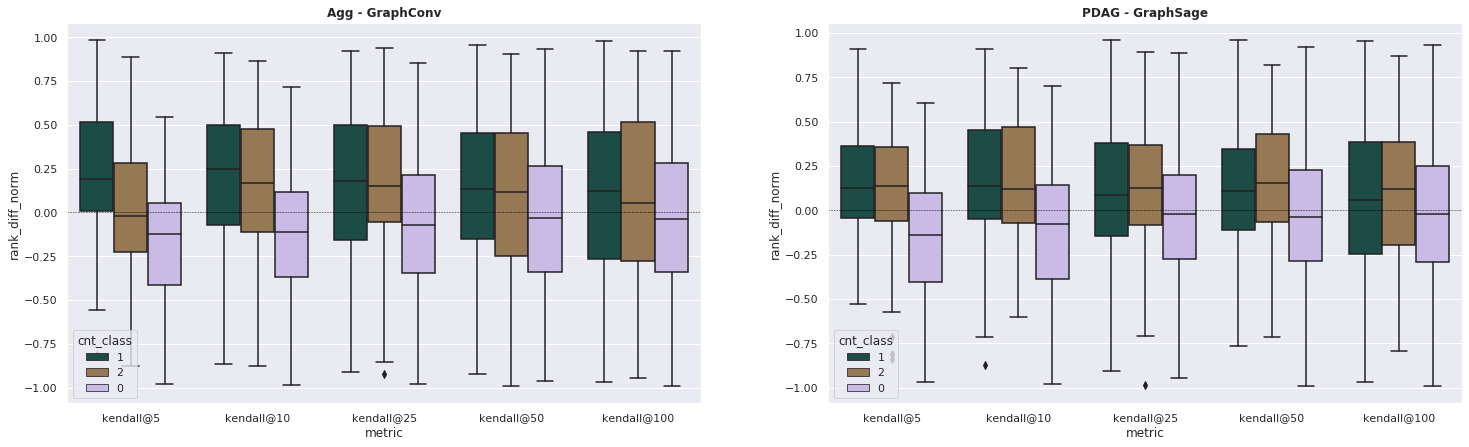

In [9]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(25, 7))
g = sns.boxplot(
        data=df_tot_graphConv_aggSimp,
        x='metric', y='rank_diff_norm', 
        palette='cubehelix', hue='cnt_class', ax=ax[0])
g.axhline(0, ls='--', color='black', linewidth=0.5)
ax[0].set_title(f'Agg - GraphConv', weight='bold')

g = sns.boxplot(
        data=df_tot_graphSage_tempEdges,
        x='metric', y='rank_diff_norm', 
        palette='cubehelix', hue='cnt_class', ax=ax[1])
g.axhline(0, ls='--', color='black', linewidth=0.5)
ax[1].set_title(f'PDAG - GraphSage', weight='bold')

## Linear regression  
Linear regression between covariables :
- nb occurences in training set
- time decay 

and true ranking in test set, i.e order of appearance.

Recall that **coefficient of determination** is the proportion of the variance in the dependent variable that is predictable from the independent variables. It is defined as :
$$
R^2 = 1 - \dfrac{SS_{res}}{SS_{tot}}
$$
where  
* $SS_{res} = \sum_{i}(y_i - f_i)^2$ is the **residual sum of squares**  
* $SS_{tot} = \sum_{i}(y_i - \bar y)^2$ is the **total sum of squares**. In this term, we predict values for $y_i$ with the mean of the variable $y$.


#### Agg simp - GraphConv 

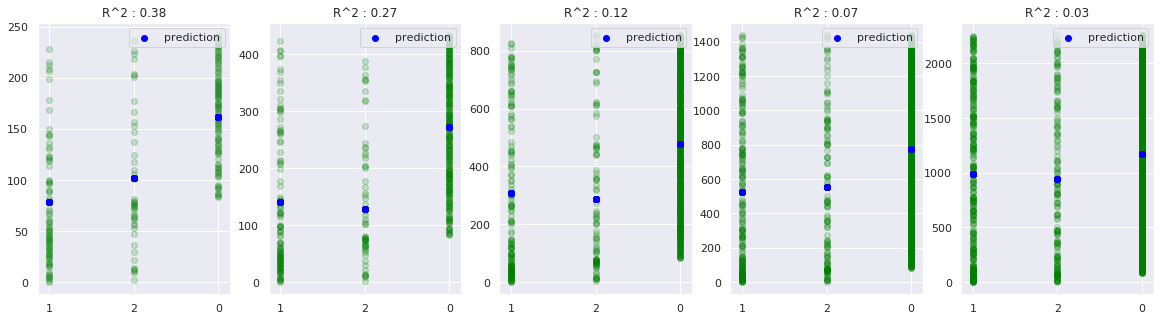

In [10]:
# cnt class ~ True Ranks
fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['true_ranks'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['true_ranks'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

As the number of timesteps considered in test set grows, the relation between number of occurences of edges and ranking in test set tends to vanish. Thus, it may influence the prediction ability of the model.  
This vanishing relation is probably caused by the fact that the number of unseen events grows significantly over time. As this category of node is poorly related to the position of events in the future timeline, the overall performance is diminishing.

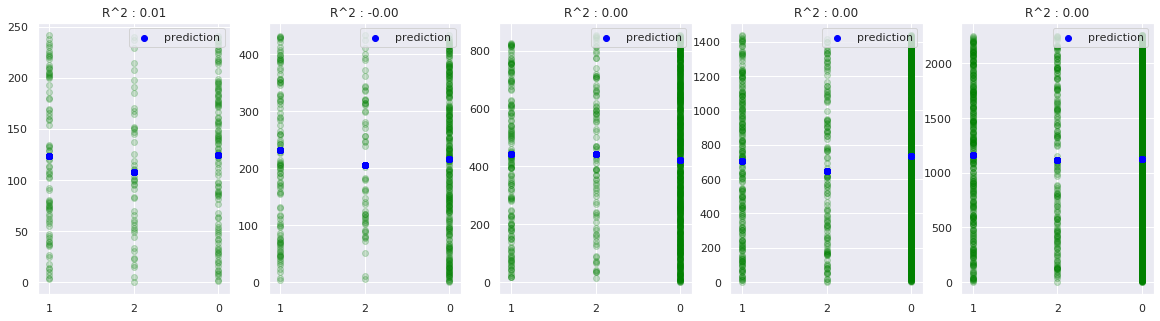

In [11]:
# Cnt class ~ pred ranks
# No causality between 2 variables, although there exists one between cnt class and true ranks

fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['pred_ranks'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['pred_ranks'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

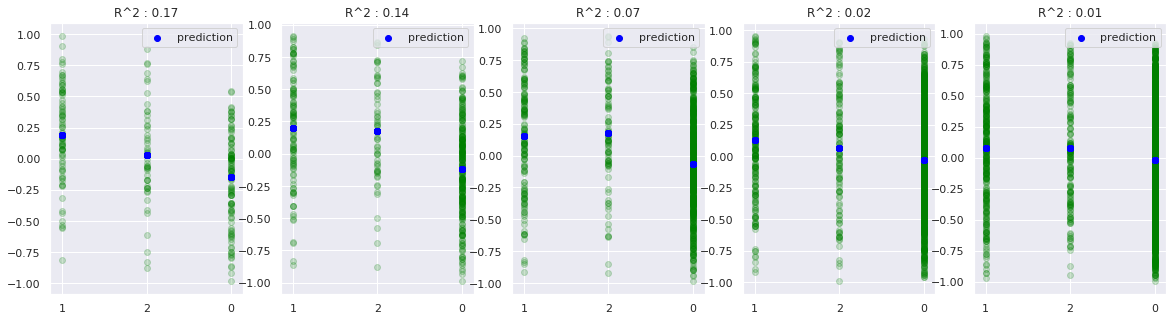

In [12]:
# Cnt class ~ rank diff norm
# The more an edge occured in the past, the more chances it has to be ranked higher by model (i.e model predict it will occur soon).

fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['rank_diff_norm'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['rank_diff_norm'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

#### PDAG - GraphSage

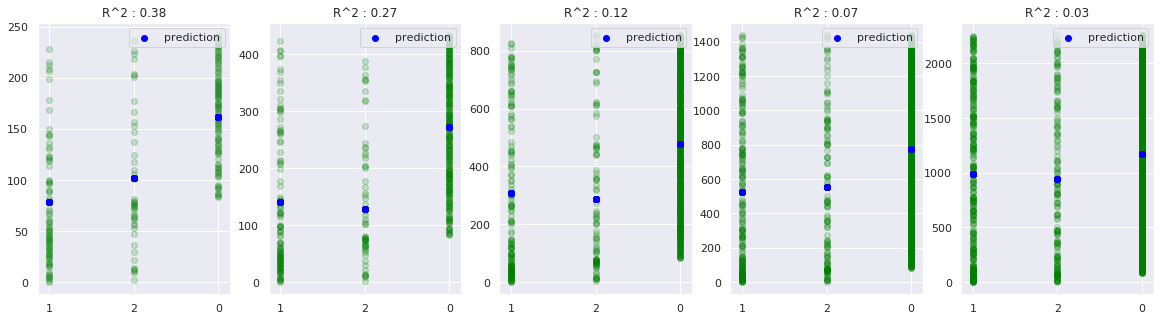

In [13]:
# cnt class ~ True Ranks
fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['true_ranks'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['true_ranks'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

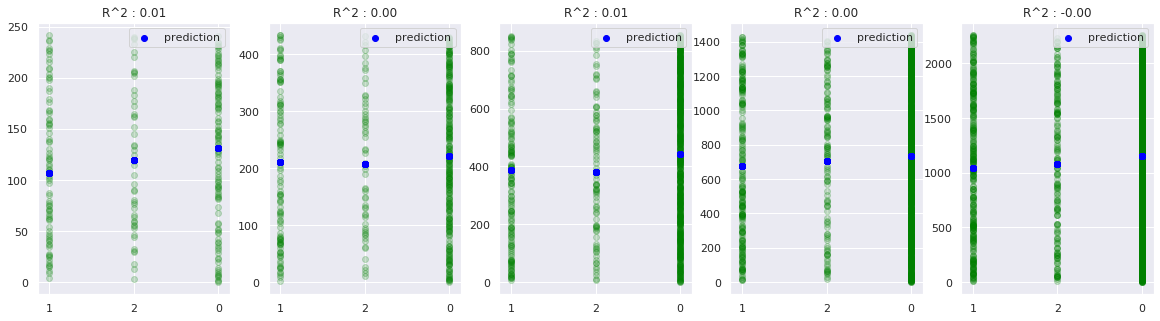

In [14]:
# Cnt class ~ pred ranks
# No causality between 2 variables, although there exists one between cnt class and true ranks

fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['pred_ranks'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['pred_ranks'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

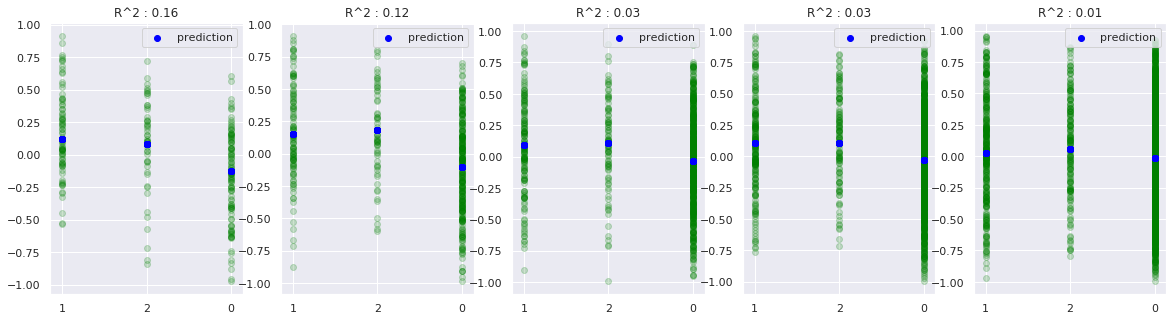

In [15]:
# Cnt class ~ rank diff norm
# The more an edge occured in the past, the more chances it has to be ranked higher by model (i.e model predict it will occur soon).

fig, ax = plt.subplots(1, len(metrics_at), figsize=(20, 5))

for i, metric in enumerate(metrics_at):
    df = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    X = np.array(df['cnt_class']).reshape(-1, 1)
    enc = OneHotEncoder(sparse=False)
    X_ohe = enc.fit_transform(X)
    y = np.array(df['rank_diff_norm'])

    model = LinearRegression()
    model.fit(X_ohe, y)
    preds = model.predict(X_ohe)

    ax[i].scatter(df['cnt_class'], df['rank_diff_norm'], alpha=0.2, color='green')
    ax[i].scatter(df['cnt_class'], preds, label='prediction', color='blue')
    ax[i].set_title(f'R^2 : {model.score(X_ohe, y):.2f}')
    ax[i].legend(loc='upper right')

Selection of edges present in first 5 timesteps, and display of their rank difference between true and predicted values over time.

In [ ]:
labs_5 = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges.metric == 'kendall@5'].label.values

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

df_filt_5 = pd.DataFrame()

for metric in metrics_at:
    df = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges.metric == metric]
    df['keep'] = df['label'].apply(lambda x: True if x in labs_5 else False)
    df_tmp = df[df['keep']==True]
    df_filt_5 = pd.concat([df_filt_5, df_tmp])
    
g = sns.boxplot(
    data=df_filt_5,
    x='metric', y='rank_diff_norm', 
    palette='cubehelix', hue='cnt_class')
g.axhline(0, ls='--', color='black', linewidth=0.5)
plt.title(f'{feat_structs[0]} - {model_name}', weight='bold');
    

#### Analysis `true_ranks` vs `predicted_ranks`

1) dividing edges according to time : performance for 3 batches over time

The first third of predicted edges ranks are more correlated to true ranks.

2) dividing edges according to their frequency of occurence in training

The edges that have been seen between 1 and 5 times are more well predicted than other edges when considering short window of time for prediction (@5 for example). However, on long term, edges that have been seen more than 5 times are more well predicted.

Text(0.5, 1.0, 'Kendall Tau : 0.122')

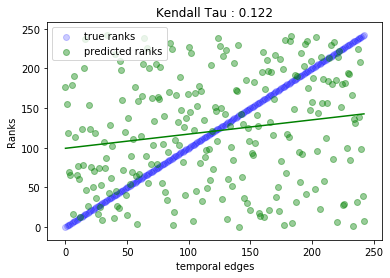

In [ ]:
# Kendall@5
metric = 'kendall@5'

# Filter df
df_tmp_pdag = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]

y = df_tmp_pdag.true_ranks
y_pred = df_tmp_pdag.pred_ranks

lr = LinearRegression()
lr.fit(np.array(range(len(y))).reshape(-1, 1), y_pred)
y_lr = lr.predict(np.array(range(len(y))).reshape(-1, 1))

# Plot
plt.scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
plt.scatter(range(len(y)), y_pred, color='green', alpha=0.4, label='predicted ranks')
plt.plot(range(len(y)), y_lr, color='green')
plt.legend()
plt.xlabel('temporal edges')
plt.ylabel('Ranks')
plt.title(f'Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')

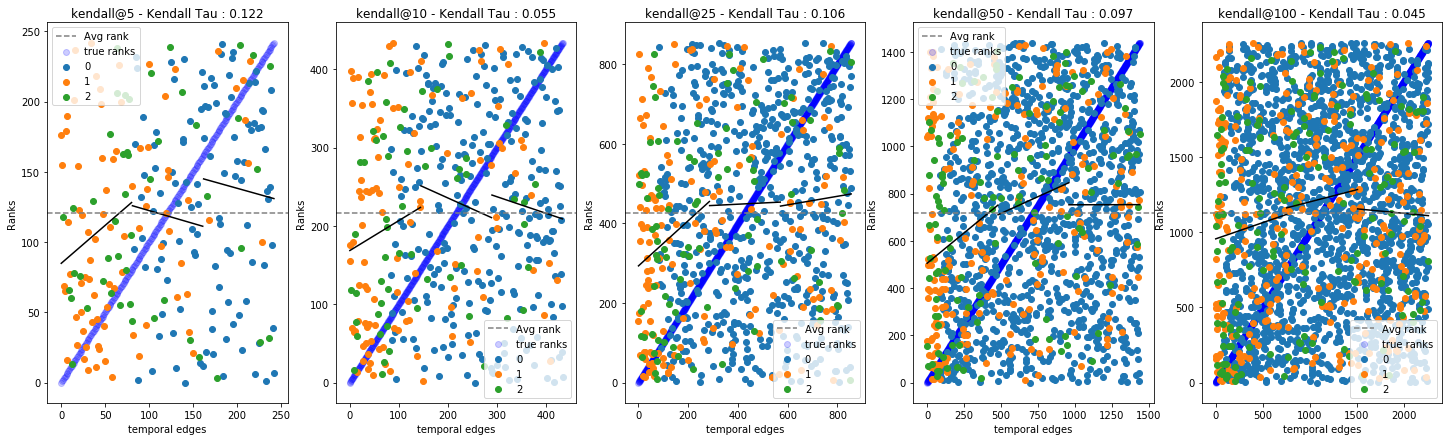

In [ ]:
fig, ax = plt.subplots(1, len(metrics_at), figsize=(25, 7))
split = 3

for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]

    y = df_tmp_pdag.true_ranks
    y_pred = df_tmp_pdag.pred_ranks
    c = df_tmp_pdag.cnt

    lr_preds = []
    for i, (X, arr) in enumerate(zip(np.array_split(np.array(y), split), np.array_split(np.array(y_pred), split))):
        #X = np.array(range(len(arr))).reshape(-1, 1) #+ np.ones(len(X)) + (i * len(arr))
        X = X.reshape(-1, 1)
        lr = LinearRegression(fit_intercept=True).fit(X, arr)
        #print(lr.coef_, lr.intercept_)
        lr_pred = lr.predict(X)
        lr_preds.append(lr_pred)
        ax[idx].plot(X, lr_pred, color='black')

    # Plot
    ax[idx].axhline(np.mean(y_pred), linestyle='--', color='grey', label='Avg rank')
    ax[idx].scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
    groups = df_tmp_pdag.groupby('cnt_class')
    for name, group in groups:
        ax[idx].scatter(group.true_ranks, group.pred_ranks, label=name)
    #ax[idx].scatter(x=range(len(y)), y=y_pred, c=c, cmap='Greens', label='predicted ranks')
    ax[idx].legend()
    ax[idx].set_xlabel('temporal edges')
    ax[idx].set_ylabel('Ranks')
    ax[idx].set_title(f'{metric} - Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')
    

In [ ]:
vals = []
unseens = []
for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    n = df_tmp_pdag.shape[0]
    df_tmp_pdag = df_tmp_pdag.head(int(n/3))
    m = np.mean(df_tmp_pdag.cnt.values)
    cnt_unseen = len(df_tmp_pdag.cnt.values[df_tmp_pdag.cnt.values==0]) / n
    vals.append(m)
    unseens.append(cnt_unseen)
    if idx >= 1:
        val = (m - vals[idx-1]) / vals[idx-1]
    else:
        val = 0
    print(f'{metric:<11} - mean cnt for first 1/3 of data : {m:.3f} ({100*val:<6.1f}%) - cnt unseen : {cnt_unseen:.2f} - Kendall tau : {stats.kendalltau(df_tmp_pdag.true_ranks.values, df_tmp_pdag.pred_ranks.values)[0]:.3f}')

kendall@5   - mean cnt for first 1/3 of data : 28.630 (0.0   %) - cnt unseen : 0.00 - Kendall tau : 0.129
kendall@10  - mean cnt for first 1/3 of data : 21.738 (-24.1 %) - cnt unseen : 0.08 - Kendall tau : 0.090
kendall@25  - mean cnt for first 1/3 of data : 15.382 (-29.2 %) - cnt unseen : 0.17 - Kendall tau : 0.127
kendall@50  - mean cnt for first 1/3 of data : 13.775 (-10.4 %) - cnt unseen : 0.21 - Kendall tau : 0.122
kendall@100 - mean cnt for first 1/3 of data : 10.280 (-25.4 %) - cnt unseen : 0.23 - Kendall tau : 0.055


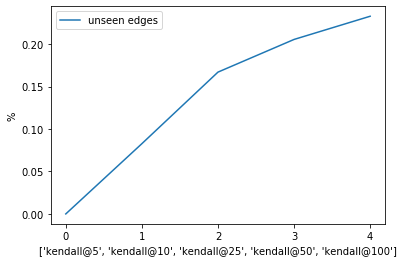

In [ ]:
plt.plot(unseens, label='unseen edges')
plt.xticks(range(5))
plt.xlabel(metrics_at)
plt.ylabel('%')
plt.legend()

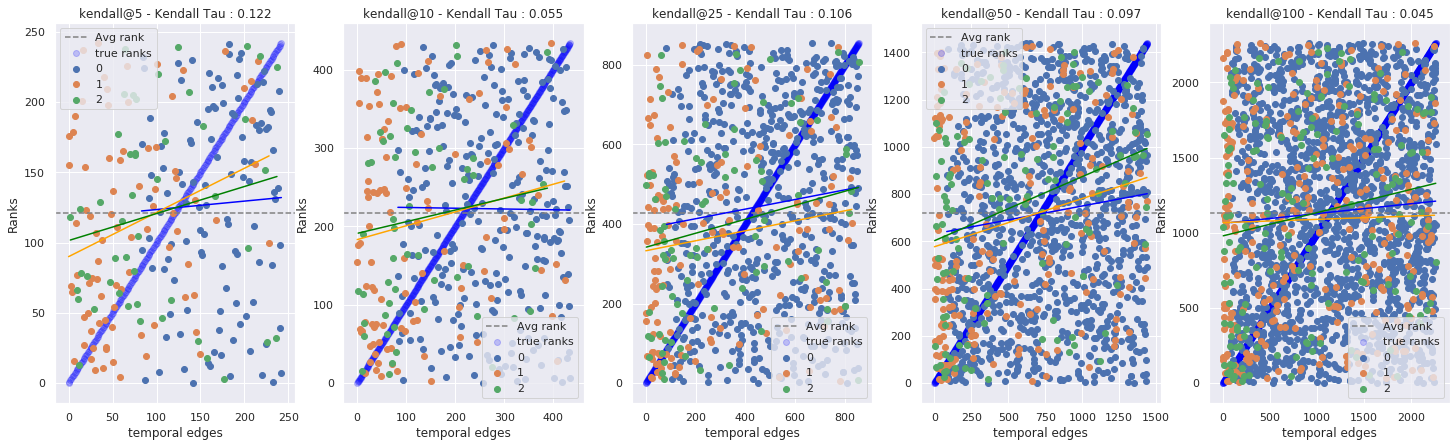

In [ ]:
fig, ax = plt.subplots(1, len(metrics_at), figsize=(25, 7))
split = 3
colors = ['blue', 'orange', 'green']

for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    y = df_tmp_pdag.true_ranks
    y_pred = df_tmp_pdag.pred_ranks

    # Plot
    ax[idx].axhline(np.mean(y_pred), linestyle='--', color='grey', label='Avg rank')
    ax[idx].scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
    groups = df_tmp_pdag.groupby('cnt_class')
    for j, (name, group) in enumerate(groups):
        ax[idx].scatter(group.true_ranks, group.pred_ranks, label=name)
        X = np.array(group.true_ranks).reshape(-1, 1)
        lr = LinearRegression(fit_intercept=True).fit(X, np.array(group.pred_ranks))
        lr_pred = lr.predict(X)
        ax[idx].plot(X, lr_pred, color=colors[j])
    ax[idx].legend()
    ax[idx].set_xlabel('temporal edges')
    ax[idx].set_ylabel('Ranks')
    ax[idx].set_title(f'{metric} - Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')


In [ ]:
vals = []
unseens = []
for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphSage_tempEdges.loc[df_tot_graphSage_tempEdges['metric']==metric]
    n = df_tmp_pdag.shape[0]
    df_tmp_pdag_1 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='1']
    df_tmp_pdag_2 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='2']
    df_tmp_pdag_0 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='0']
    s1 = f'Kendall tau (1) : {stats.kendalltau(df_tmp_pdag_1.true_ranks.values, df_tmp_pdag_1.pred_ranks.values)[0]:.3f}'
    s2 = f'Kendall tau (2) : {stats.kendalltau(df_tmp_pdag_2.true_ranks.values, df_tmp_pdag_2.pred_ranks.values)[0]:.3f}'
    s0 = f'Kendall tau (0) : {stats.kendalltau(df_tmp_pdag_0.true_ranks.values, df_tmp_pdag_0.pred_ranks.values)[0]:.3f}'
    print(f'{metric:<11} - {s1} - {s2} - {s0}')


kendall@5   - Kendall tau (1) : 0.137 - Kendall tau (2) : 0.124 - Kendall tau (0) : 0.034
kendall@10  - Kendall tau (1) : 0.113 - Kendall tau (2) : 0.121 - Kendall tau (0) : -0.006
kendall@25  - Kendall tau (1) : 0.102 - Kendall tau (2) : 0.135 - Kendall tau (0) : 0.071
kendall@50  - Kendall tau (1) : 0.146 - Kendall tau (2) : 0.202 - Kendall tau (0) : 0.072
kendall@100 - Kendall tau (1) : 0.025 - Kendall tau (2) : 0.119 - Kendall tau (0) : 0.041


Text(0.5, 1.0, 'Kendall Tau : -0.101')

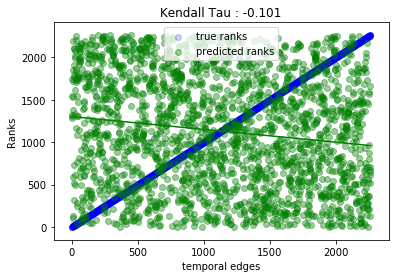

In [ ]:
# Kendall@5
methods = ['GraphConv']

# Filter df
df_tmp_graphConv = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]

y = df_tmp_graphConv.true_ranks
y_pred = df_tmp_graphConv.pred_ranks

lr = LinearRegression()
lr.fit(np.array(range(len(y))).reshape(-1, 1), y_pred)
y_lr = lr.predict(np.array(range(len(y))).reshape(-1, 1))

# Plot
plt.scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
plt.scatter(range(len(y)), y_pred, color='green', alpha=0.4, label='predicted ranks')
plt.plot(range(len(y)), y_lr, color='green')
plt.legend()
plt.xlabel('temporal edges')
plt.ylabel('Ranks')
plt.title(f'Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')

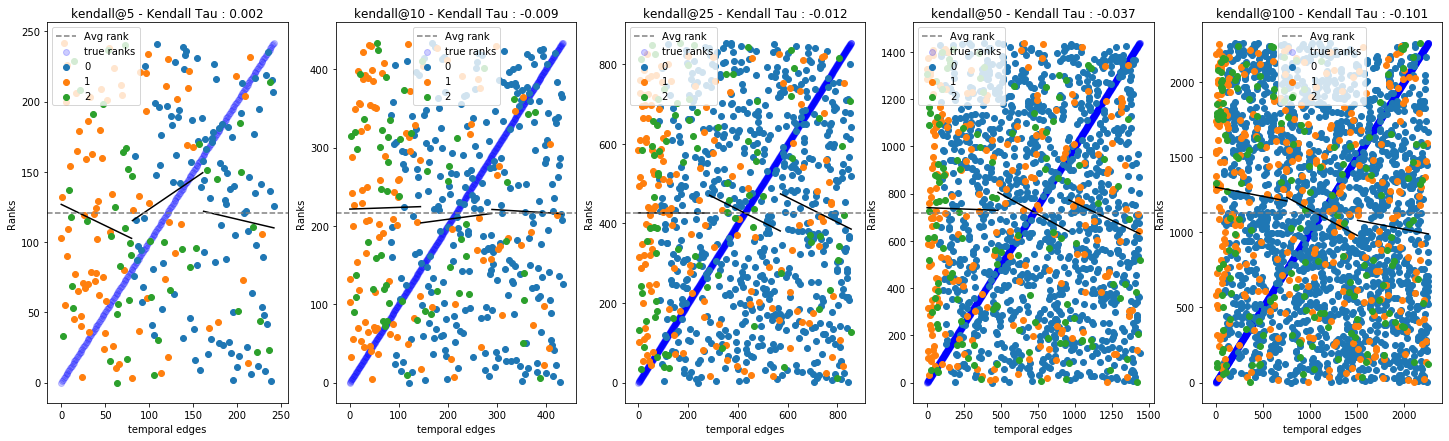

In [ ]:
fig, ax = plt.subplots(1, len(metrics_at), figsize=(25, 7))
split = 3

for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]

    y = df_tmp_pdag.true_ranks
    y_pred = df_tmp_pdag.pred_ranks
    c = df_tmp_pdag.cnt

    lr_preds = []
    for i, (X, arr) in enumerate(zip(np.array_split(np.array(y), split), np.array_split(np.array(y_pred), split))):
        #X = np.array(range(len(arr))).reshape(-1, 1) #+ np.ones(len(X)) + (i * len(arr))
        X = X.reshape(-1, 1)
        lr = LinearRegression(fit_intercept=True).fit(X, arr)
        #print(lr.coef_, lr.intercept_)
        lr_pred = lr.predict(X)
        lr_preds.append(lr_pred)
        ax[idx].plot(X, lr_pred, color='black')

    # Plot
    ax[idx].axhline(np.mean(y_pred), linestyle='--', color='grey', label='Avg rank')
    ax[idx].scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
    groups = df_tmp_pdag.groupby('cnt_class')
    for name, group in groups:
        ax[idx].scatter(group.true_ranks, group.pred_ranks, label=name)
    #ax[idx].scatter(x=range(len(y)), y=y_pred, c=c, cmap='Greens', label='predicted ranks')
    ax[idx].legend()
    ax[idx].set_xlabel('temporal edges')
    ax[idx].set_ylabel('Ranks')
    ax[idx].set_title(f'{metric} - Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')
    

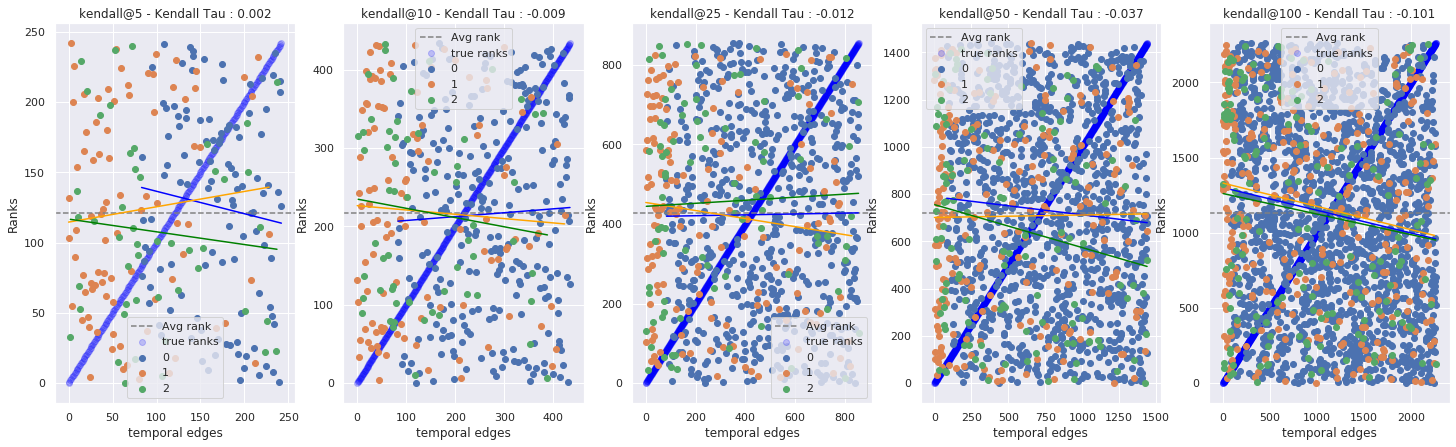

In [ ]:
fig, ax = plt.subplots(1, len(metrics_at), figsize=(25, 7))
split = 3
colors = ['blue', 'orange', 'green']

for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]
    y = df_tmp_pdag.true_ranks
    y_pred = df_tmp_pdag.pred_ranks

    # Plot
    ax[idx].axhline(np.mean(y_pred), linestyle='--', color='grey', label='Avg rank')
    ax[idx].scatter(range(len(y)), y, color='blue', alpha=0.2, label='true ranks')
    groups = df_tmp_pdag.groupby('cnt_class')
    for j, (name, group) in enumerate(groups):
        ax[idx].scatter(group.true_ranks, group.pred_ranks, label=name)
        X = np.array(group.true_ranks).reshape(-1, 1)
        lr = LinearRegression(fit_intercept=True).fit(X, np.array(group.pred_ranks))
        lr_pred = lr.predict(X)
        ax[idx].plot(X, lr_pred, color=colors[j])
    ax[idx].legend()
    ax[idx].set_xlabel('temporal edges')
    ax[idx].set_ylabel('Ranks')
    ax[idx].set_title(f'{metric} - Kendall Tau : {stats.kendalltau(y, y_pred)[0]:.3f}')


In [ ]:
vals = []
unseens = []
for idx, metric in enumerate(metrics_at):
    # Filter df
    df_tmp_pdag = df_tot_graphConv_aggSimp.loc[df_tot_graphConv_aggSimp['metric']==metric]
    n = df_tmp_pdag.shape[0]
    df_tmp_pdag_1 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='1']
    df_tmp_pdag_2 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='2']
    df_tmp_pdag_0 = df_tmp_pdag.loc[df_tmp_pdag['cnt_class']=='0']
    s1 = f'Kendall tau (1) : {stats.kendalltau(df_tmp_pdag_1.true_ranks.values, df_tmp_pdag_1.pred_ranks.values)[0]:.3f}'
    s2 = f'Kendall tau (2) : {stats.kendalltau(df_tmp_pdag_2.true_ranks.values, df_tmp_pdag_2.pred_ranks.values)[0]:.3f}'
    s0 = f'Kendall tau (0) : {stats.kendalltau(df_tmp_pdag_0.true_ranks.values, df_tmp_pdag_0.pred_ranks.values)[0]:.3f}'
    print(f'{metric:<11} - {s1} - {s2} - {s0}')


kendall@5   - Kendall tau (1) : 0.058 - Kendall tau (2) : -0.076 - Kendall tau (0) : -0.093
kendall@10  - Kendall tau (1) : -0.013 - Kendall tau (2) : -0.071 - Kendall tau (0) : 0.022
kendall@25  - Kendall tau (1) : -0.080 - Kendall tau (2) : 0.054 - Kendall tau (0) : 0.005
kendall@50  - Kendall tau (1) : 0.012 - Kendall tau (2) : -0.118 - Kendall tau (0) : -0.047
kendall@100 - Kendall tau (1) : -0.119 - Kendall tau (2) : -0.100 - Kendall tau (0) : -0.096
